# Lens parameters

Here I try to generalize the properties of different lens and try to understand the relation between different lens parameters.

~ Saif 08/2021

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from gw_lens_dir.L_unlensed import Lunlensed
%matplotlib inline

### Point mass lens

Refer to section 2.1 in Takahashi-Nakamura

In [2]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec

def mag(ml, y, lens):
    
    if lens == 'pm':
        mu_plus = np.abs(0.5 + (y ** 2 + 2) / (2 * y * (y ** 2 + 4) ** 0.5))
        mu_minus = np.abs(0.5 - (y ** 2 + 2) / (2 * y * (y ** 2 + 4) ** 0.5))
    
    elif lens == 'sis':
        mu_plus = np.abs(1 + 1 / y)
        mu_minus = np.abs(-1 + 1 / y)
    
    return mu_plus, mu_minus

def td(ml, y, lens):
    
    if lens == 'pm':
        first_term = (y * (y ** 2 + 4) ** 0.5) / 2
        second_term = np.log(((y ** 2 + 4) ** 0.5 + y) / ((y ** 2 + 4) ** 0.5 - y))
        tds = 4 * ml * (first_term + second_term)
    
    elif lens == 'sis':
        tds = 8 * ml * y
    
    return tds

In [3]:
y = np.linspace(0.1, 1, 50)
ml = [10 * solar_mass, 50 * solar_mass, 100 * solar_mass]

flux_ratio_pm_1 = np.zeros_like(y)
flux_ratio_pm_2 = np.zeros_like(y)
flux_ratio_sis_1 = np.zeros_like(y)
flux_ratio_sis_2 = np.zeros_like(y)
tds_pm_1 = np.zeros_like(y)
tds_pm_2 = np.zeros_like(y)
tds_sis_1 = np.zeros_like(y)
tds_sis_2 = np.zeros_like(y)

for i in range(y.shape[0]):
    flux_ratio_pm_1[i] = mag(ml[0], y[i], lens = 'pm')[1] / mag(ml[0], y[i], lens = 'pm')[0]
    flux_ratio_pm_2[i] = mag(ml[1], y[i], lens = 'pm')[1] / mag(ml[1], y[i], lens = 'pm')[0]
    flux_ratio_sis_1[i] = mag(ml[0], y[i], lens = 'sis')[1] / mag(ml[0], y[i], lens = 'sis')[0]
    flux_ratio_sis_2[i] = mag(ml[1], y[i], lens = 'sis')[1] / mag(ml[1], y[i], lens = 'sis')[0]
    tds_pm_1[i] = td(ml[0], y[i], lens = 'pm')
    tds_pm_2[i] = td(ml[1], y[i], lens = 'pm')
    tds_sis_1[i] = td(ml[0], y[i], lens = 'sis')
    tds_sis_2[i] = td(ml[1], y[i], lens = 'sis')

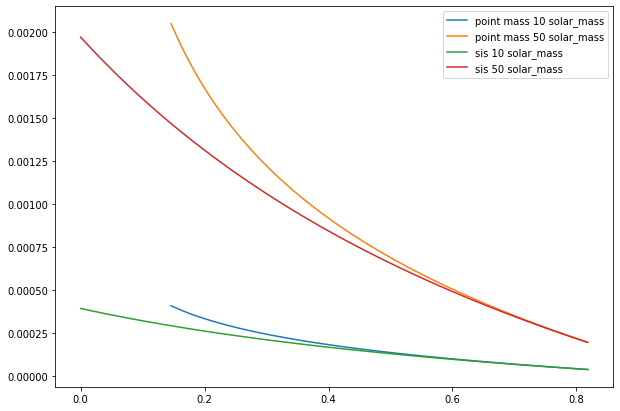

In [4]:
plt.figure(figsize = (10, 7))
plt.plot(flux_ratio_pm_1, tds_pm_1, label = 'point mass 10 solar_mass')
plt.plot(flux_ratio_pm_2, tds_pm_2, label = 'point mass 50 solar_mass')
plt.plot(flux_ratio_sis_1, tds_sis_1, label = 'sis 10 solar_mass')
plt.plot(flux_ratio_sis_2, tds_sis_2, label = 'sis 50 solar_mass')
plt.legend();  

In [5]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
giga_parsec = 1.02927125 * 10**17 #[giga_parsec] = sec

default_strain_params = {
    'theta_s': 0.,
    'phi_s': 0.,
    'theta_l': 0.,
    'phi_l': 0.,
    'mcz': 18.79 * solar_mass,
    'dist': 1.58 * giga_parsec,
    'eta': 0.25,
    'tc': 0.,
    'phi_c': 0.
}
model = Lunlensed(default_strain_params)

In [6]:
def snr(ml, y, lens):
    
    M = (default_strain_params['mcz'] /np.power(default_strain_params['eta'], 3/5))
    low_limit = 20
    upper_limit = 1 / (np.power(6, 3/2) * np.pi * M)
    
    
    
    if lens == 'pm':
        amp_fact_pm = lambda f: np.sqrt(mag(ml, y, lens)[0]) - 1j * np.sqrt(mag(ml, y, lens)[1]) * \
                    np.exp(2 * np.pi * 1j * f * td(ml, y, lens))
        integrand = lambda f: np.power(np.abs(model.hI(f) * amp_fact_pm(f)), 2) / model.Sn(f)

        snr_temp, snr_err = sp.integrate.quad(integrand, low_limit, upper_limit)
        snr_sq = 4 * snr_temp
        snr = np.sqrt(snr_sq)
        
    return snr, low_limit, upper_limit

In [53]:
snr(456 * solar_mass, y = 0.1, lens = 'pm')

(65.8649220033709, 20, 101.84620327015129)

In [54]:
def contour_plot(ml_low_limit, 
                 ml_up_limit, 
                 y_low_limit, 
                 y_up_limit,
                 lens, 
                 pts = 70): 
    
    """ lens param should be string ('pm' or 'sis') 
    """
    
    ml_mesh, y_mesh = np.meshgrid(np.linspace(ml_low_limit, ml_up_limit, pts), np.linspace(y_low_limit, y_up_limit, pts))
    ml_flatten = ml_mesh.flatten()
    y_flatten = y_mesh.flatten()
    snr_flat = np.zeros_like(y_flatten)

    for i in range(ml_flatten.shape[0]):
        snr_flat[i] = snr(ml_flatten[i], y_flatten[i], lens = lens)[0]
        
    snr_mesh = snr_flat.reshape(pts, pts)
    
    td_mesh = np.array([td(ml_flatten[i], y_flatten[i], lens = lens) for i in range(ml_flatten.shape[0])]).reshape(pts, pts)
    flux_ratio_mesh = np.array([mag(ml_flatten[i], y_flatten[i], lens = lens)[1] / mag(ml_flatten[i], y_flatten[i], lens = lens)[0] for i in range(ml_flatten.shape[0])]).reshape(pts, pts)
    
    plt.figure(figsize = (10, 8))
    ax1 = plt.subplot(211)
    cs1 = ax1.contour(flux_ratio_mesh, td_mesh ,snr_mesh, 30)
    ax1.set(ylabel = 'td', xlabel = 'flux_ratio')
    ax1.clabel(cs1, inline=True, fontsize=10)
      
    ax2 = plt.subplot(212)
    cs2 = ax2.contour(y_mesh, ml_mesh, snr_mesh, 30)
    ax2.set(ylabel = 'ml', xlabel = 'y')
    ax2.clabel(cs2, inline=True, fontsize=10)
  
    #return ml_flatten, y_flatten, snr_flat

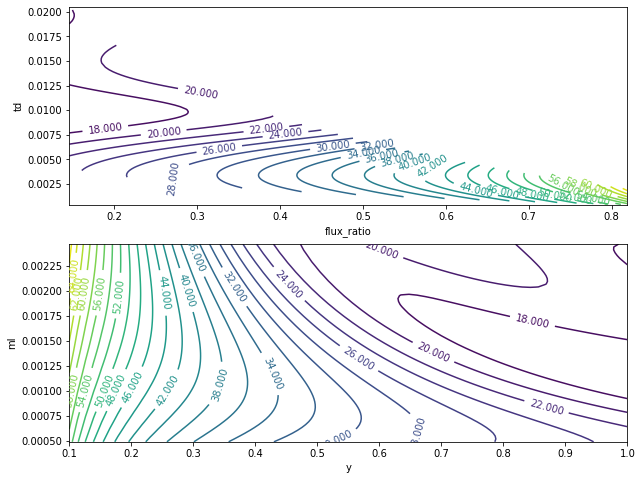

In [55]:
z = contour_plot(100 * solar_mass,
             500 * solar_mass,
             0.1, 
             1,
             lens = 'pm'
            )